In [1]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

D:\Conda\envs\test_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f = FAIR(ch4_method="Thornhill2021")
f.define_time(1750, 2300, 1)  # start, end, step
scenarios = [
    "high-extension",
    "high-overshoot",
    "medium-overshoot",
    "medium-extension",
    "low",
    "verylow",
    "verylow-overshoot",
]
f.define_scenarios(scenarios)
fair_params_1_4_1_file = 'data/calibrated_constrained_ensemble/calibrated_constrained_parameters_calibration1.4.1.csv'
df_configs = pd.read_csv(fair_params_1_4_1_file, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)
fair_species_configs_1_4_1_file = 'data/calibrated_constrained_ensemble/species_configs_properties_calibration1.4.1.csv'
species, properties = read_properties(filename=fair_species_configs_1_4_1_file)
f.define_species(species, properties)
f.allocate()
f.fill_from_csv(
    emissions_file='data/calibrated_constrained_ensemble/extensions_1750-2500.csv',
    forcing_file='data/calibrated_constrained_ensemble/volcanic_solar.csv',
)


f.forcing.sel(specie="Volcanic")
fill(
    f.forcing,
    f.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    f.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
    specie="Solar",
)
f.fill_species_configs(fair_species_configs_1_4_1_file)
f.override_defaults(fair_params_1_4_1_file)
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)
initialise(f.ocean_heat_content_change, 0)
f.run()



Running 5887 projections in parallel: 100%|██████████| 550/550 [00:42<00:00, 12.86timesteps/s]


Text(0, 0.5, 'W/m2')

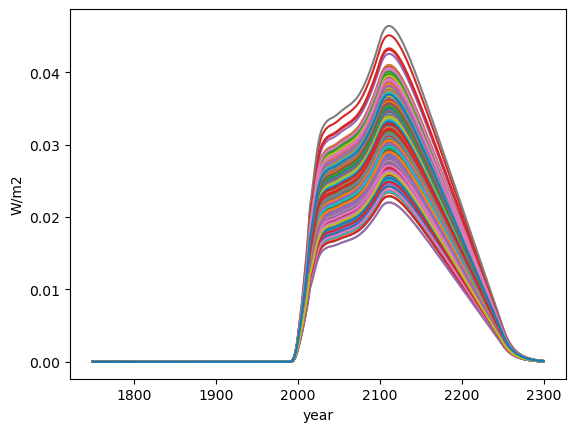

In [3]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='high-extension', specie='HFC-134a')], label=f.configs);
#pl.title('ssp119: methane forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

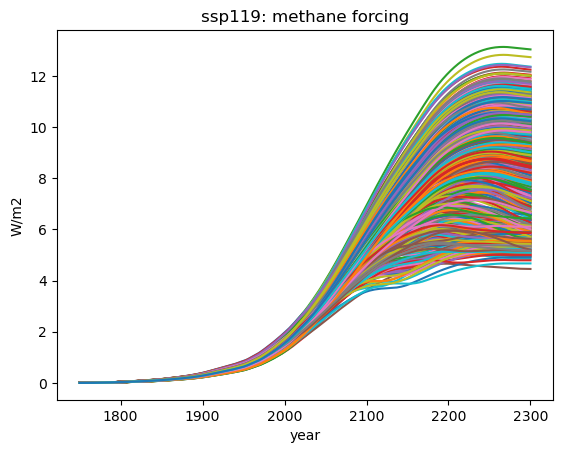

In [4]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='high-extension', specie='CO2')], label=f.configs);
pl.title('ssp119: methane forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Modeling for all initial co2 emissions

In [2]:
co2_emissions = [0, 20, 40, 60]
models = {}

for co2_emission in co2_emissions:
    # initializations
    f = FAIR(ch4_method="Thornhill2021")
    f.define_time(1750, 2300, 1)  # start, end, step
    scenarios = [
        "high-extension",
        "high-overshoot",
        "medium-overshoot",
        "medium-extension",
        "low",
        "verylow",
        "verylow-overshoot",
    ]
    f.define_scenarios(scenarios)
    fair_params_1_4_1_file = 'data/calibrated_constrained_ensemble/calibrated_constrained_parameters_calibration1.4.1.csv'
    df_configs = pd.read_csv(fair_params_1_4_1_file, index_col=0)
    configs = df_configs.index  # this is used as a label for the "config" axis
    f.define_configs(configs)
    fair_species_configs_1_4_1_file = 'data/calibrated_constrained_ensemble/species_configs_properties_calibration1.4.1.csv'
    species, properties = read_properties(filename=fair_species_configs_1_4_1_file)
    f.define_species(species, properties)
    f.allocate()
    f.fill_from_csv(
        emissions_file='data/calibrated_constrained_ensemble/extensions_1750-2500.csv',
        forcing_file='data/calibrated_constrained_ensemble/volcanic_solar.csv',
    )
    #---------------------------------------------------------------------------------------------------------------------------
    #modeling
    f.emissions[272:, :, :, 0] = co2_emission

    f.forcing.sel(specie="Volcanic")
    fill(
        f.forcing,
        f.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
        specie="Volcanic",
    )
    fill(
        f.forcing,
        f.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
        specie="Solar",
    )
    f.fill_species_configs(fair_species_configs_1_4_1_file)
    f.override_defaults(fair_params_1_4_1_file)
    initialise(f.concentration, f.species_configs["baseline_concentration"])
    initialise(f.forcing, 0)
    initialise(f.temperature, 0)
    initialise(f.cumulative_emissions, 0)
    initialise(f.airborne_emissions, 0)
    initialise(f.ocean_heat_content_change, 0)
    f.run()
    models.update({co2_emission: f})


Running 5887 projections in parallel: 100%|██████████| 550/550 [00:46<00:00, 11.71timesteps/s]


Plotting the result

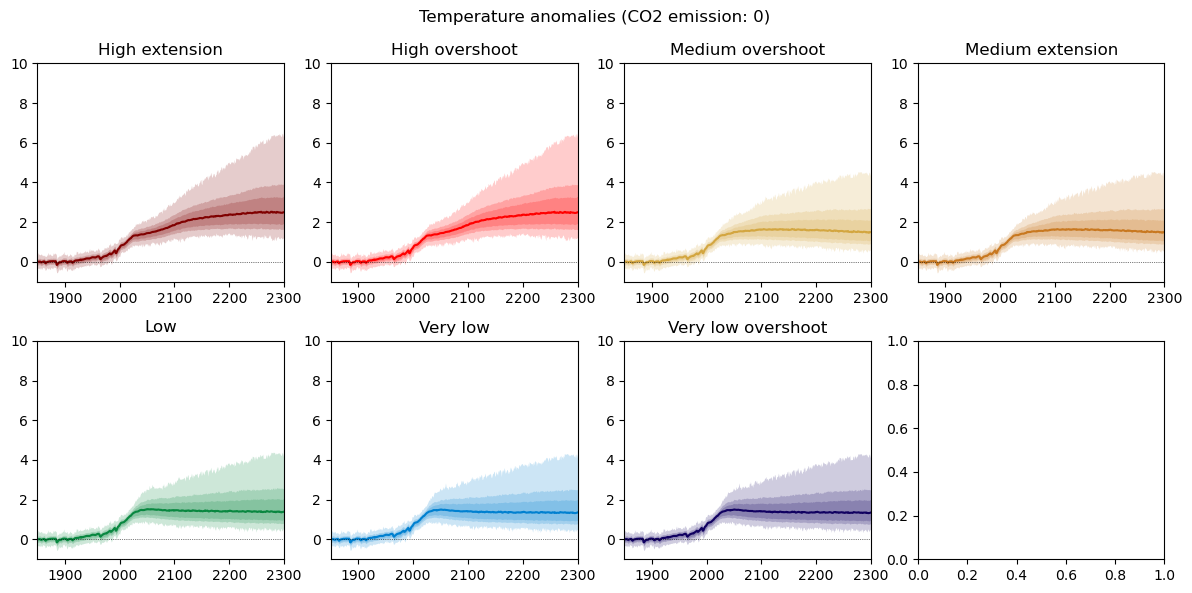

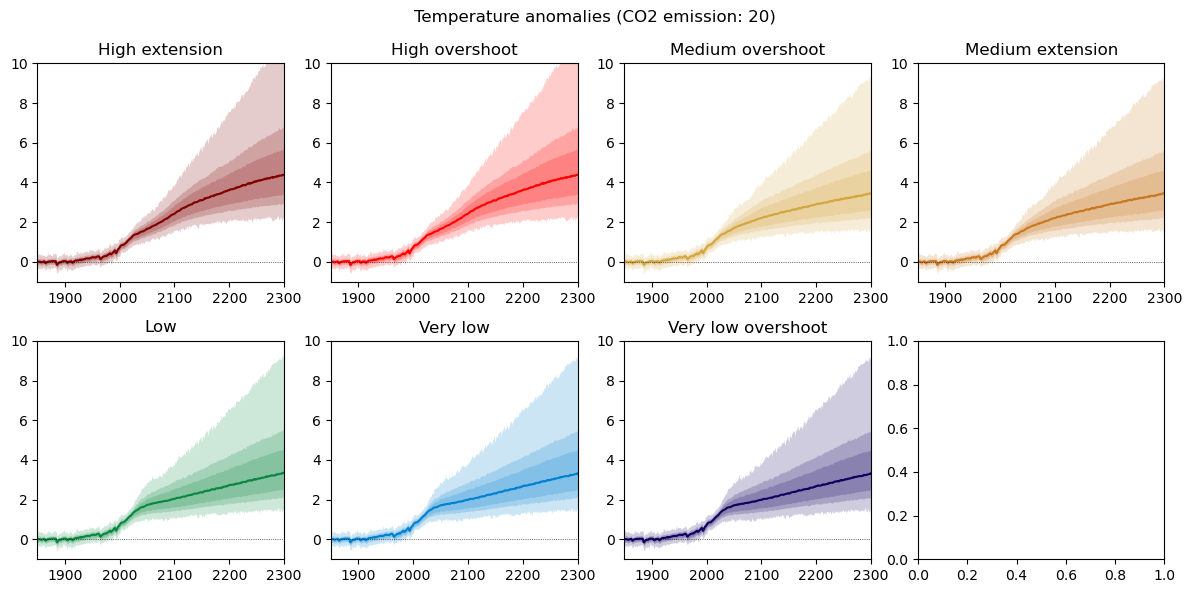

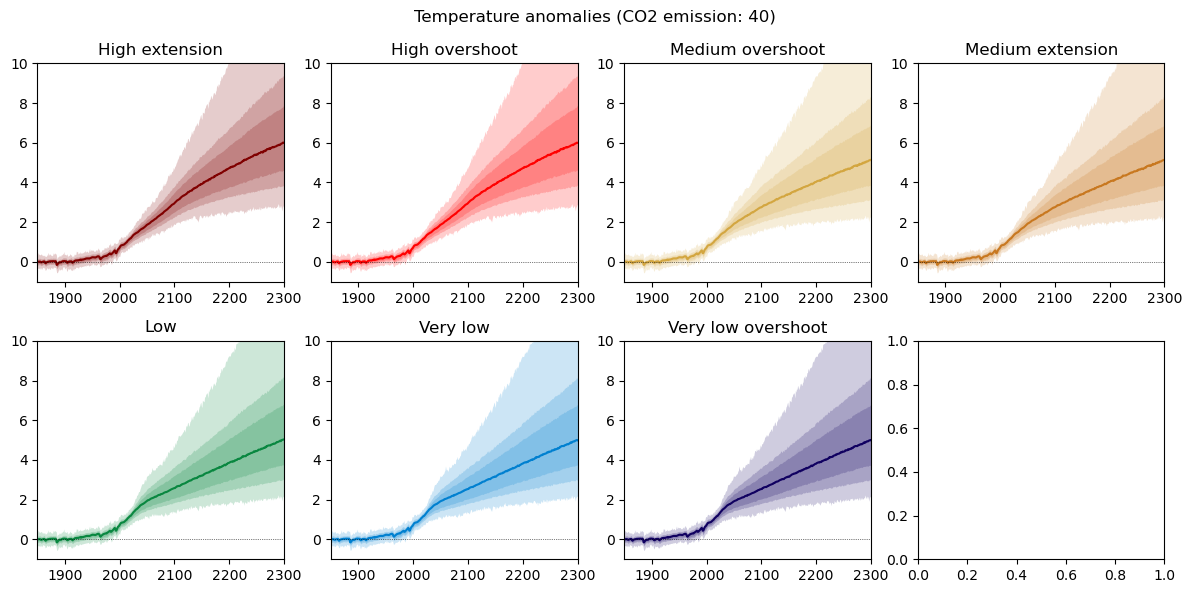

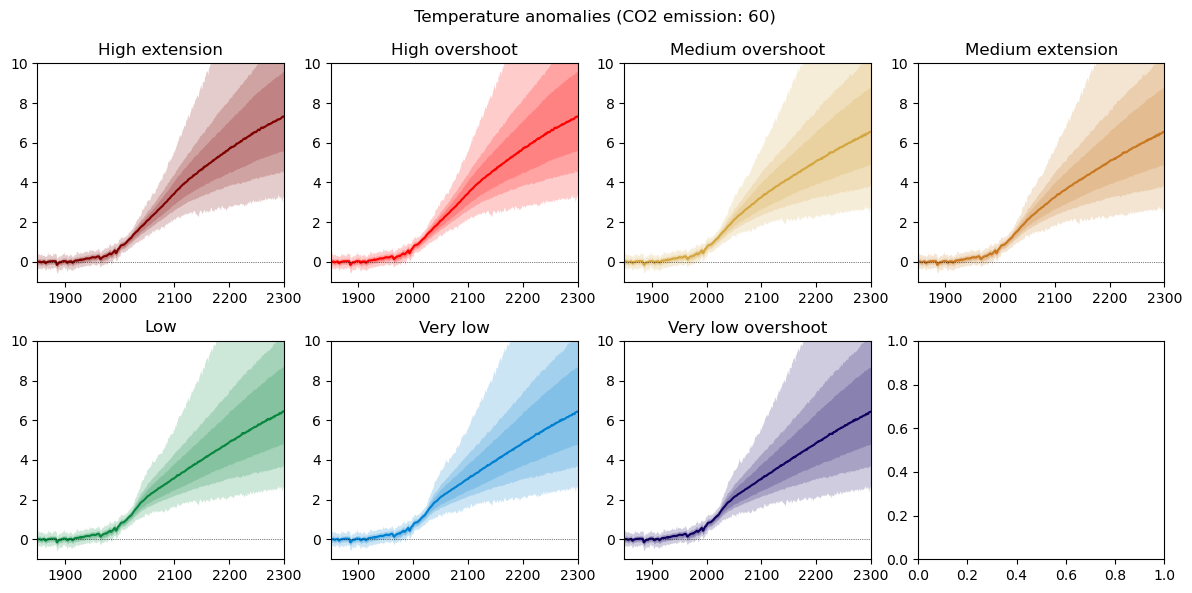

In [3]:
for co2_emission, f in models.items():
    fancy_titles = {
        'high-extension': 'High extension',
        'high-overshoot': 'High overshoot',
        'medium-extension': 'Medium extension',
        'medium-overshoot': 'Medium overshoot',
        'low': 'Low',
        'verylow': 'Very low',
        'verylow-overshoot': 'Very low overshoot',
    }

    colors = {
        'high-extension': '#800000',
        'high-overshoot': '#ff0000',
        'medium-extension': '#c87820',
        'medium-overshoot': '#d3a640',
        'low': '#098740',
        'verylow': '#0080d0',
        'verylow-overshoot': '#100060',
    }
    weights_51yr = np.ones(52)
    weights_51yr[0] = 0.5
    weights_51yr[-1] = 0.5
    fig, ax = pl.subplots(2, 4, figsize=(12, 6))

    for i, scenario in enumerate(scenarios):
        for pp in ((0, 100), (5, 95), (16, 84)):
            ax[i // 4, i % 4].fill_between(
                f.timebounds,
                np.percentile(
                    f.temperature.loc[dict(scenario=scenario, layer=0)]
                    - np.average(
                        f.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    ),
                    pp[0],
                    axis=1,
                ),
                np.percentile(
                    f.temperature.loc[dict(scenario=scenario, layer=0)]
                    - np.average(
                        f.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    ),
                    pp[1],
                    axis=1,
                ),
                color=colors[scenarios[i]],
                alpha=0.2,
                lw=0
            )

        ax[i // 4, i % 4].plot(
            f.timebounds,
            np.median(
                f.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    f.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                axis=1,
            ),
            color=colors[scenarios[i]],
        )
        ax[i // 4, i % 4].set_xlim(1850, 2300)
        ax[i // 4, i % 4].set_ylim(-1, 10)
        ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
        ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

    pl.suptitle("Temperature anomalies (CO2 emission: " + str(co2_emission) + ")")
    fig.tight_layout()